In [1]:
import pandas
import numpy as np
import tensorflow as tf
import os
import math
import random as rand
from random import random

# Data Preparation

In [2]:
trainDataFile = 'ijcnlp_dailydialog/train/dialogues_train.txt'
trainLabelsFile = 'ijcnlp_dailydialog/train/dialogues_act_train.txt' 

In [3]:
testDataFile = 'ijcnlp_dailydialog/validation/dialogues_validation.txt'
testLablesFile = 'ijcnlp_dailydialog/validation/dialogues_act_validation.txt'

In [4]:
lineSeparator = '__eou__'

In [5]:
def getData(dialogueFile, labelFile):
    with open(dialogueFile) as f:
        lines = f.readlines() 
    with open(labelFile) as f:
        labels = f.readlines()    
    
    inputs = []
    inputs_all = []
    for line in lines:
        line = line.rstrip()
        line = line.split(lineSeparator)
        inputs.append(line[:-1])
        inputs_all.extend(line[:-1])
    
    acts = []
    acts_all = []
    for label in labels:
        label = label.rstrip()
        label = label.split()
        label = np.array(map(int, label)) - 1
        acts.append(label)
        acts_all.extend(label)
        
    return (inputs_all, inputs, acts_all, acts)

In [6]:
trainX_all, trainX_data, trainY_all, trainY = getData(trainDataFile, trainLabelsFile)
_, valX_data, valY_all, valY = getData(testDataFile, testLablesFile)

In [7]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
count_vect = CountVectorizer()
trainX_vocab = count_vect.fit(trainX_all)
vocab_dict = trainX_vocab.vocabulary_

# Might want to create a global vocabulary!!

In [8]:
def create_word_embed(vocab_dict, unknown_token, pad_token, embed_size = 300, embed_path = None):
    vocab_emb = dict()
    key_list = vocab_dict.keys()
    if embed_path is not None and os.path.isfile(embed_path):
        # Write some code for creating embeddings from trained embeddings
        miss_count = 0;
        print('Something needs to be done here')
        with open(embed_path) as f:
            embeddings_index = {}
            for line in f:
                values = line.split(' ')
                word = values[0]
                embedding = np.asarray(values[1:], dtype='float32')
                embeddings_index[word] = embedding
        for i in key_list:
            if i in embeddings_index:
                vocab_emb[i] = embeddings_index[i]
            else:
                vocab_emb[i] = np.array(np.random.uniform(-1.0, 1.0, embed_size))
                miss_count += 1
        print('Missing Embeddings count: ', miss_count)
        del embeddings_index
    else:
        for i in key_list:
            vocab_emb[i] = np.array(np.random.uniform(-1.0, 1.0, embed_size))
    vocab_emb[unknown_token] = np.array(np.random.uniform(-1.0, 1.0, embed_size))
    vocab_emb[pad_token] = np.array(np.random.uniform(-1.0, 1.0, embed_size))
    return vocab_emb
            

In [9]:
embed_size = 300;
pad_token = '<pad>'
unknown_token = '<unk>'
embed_path = '/Users/abhishekjindal/Downloads/glove.840B.300d.txt'
word_emb = create_word_embed(vocab_dict, unknown_token, pad_token, embed_size, embed_path)
sent_embed_size = embed_size

Something needs to be done here
('Missing Embeddings count: ', 482)


In [10]:
def create_sentence_embed(sentence, word_emb, embed_size, unknown_token, pad_token, calc_mean = True):
    sent_emb = np.zeros(embed_size)
    if calc_mean == False:
        print('What can I do now!!')
    else:
        sent_set = set(sentence.lower().split())
        unk_index = 0;
        count = 0;
        for i in sent_set:
            if i in word_emb:
                sent_emb += word_emb[i]
                count += 1
            else:
                unk_index = 1
        if unk_index:
            sent_emb += word_emb[unknown_token]
        sent_emb = sent_emb / (count + unk_index)
    return sent_emb

# Train a classifier

In [11]:
# Parameters used.
MODEL_PATH = './model_lstm_v2.ckpt'

In [12]:
def get_sequence_length(x_data):
    seq = [];
    for i in range(len(x_data)):
        seq.append(len(x_data[i]))
    return seq

In [13]:
x_train = trainX_data
y_train = trainY

x_test = valX_data
y_test = valY

sequence_length_train = get_sequence_length(x_train)
sequence_length_test = get_sequence_length(x_test)


In [14]:
learning_rate = 0.05
#training_epochs = 7
input_size = sent_embed_size
#batch_size = 25
num_units = 128 # the number of units in the LSTM cell
number_of_classes = len(set(trainY_all))

In [15]:
def pad_data(sentence, max_length, input_size):
    sent_emb = np.array([create_sentence_embed(x, word_emb, embed_size, unknown_token, pad_token, calc_mean = True) for x in sentence])
    pad_len = max_length - len(sentence)
    temp = sent_emb
    if pad_len > 0:
        single_pad = np.zeros(input_size)
        padding = [single_pad] * pad_len
        temp = np.concatenate((sent_emb, padding))
    return temp

In [16]:
def pad_label(sentence, max_length):
    pad_len = max_length - len(sentence)
    padding = np.zeros(pad_len, dtype=int)
    temp_labels = np.concatenate((sentence, padding))
    #print(temp_labels)
    #print(type(temp_labels))
    batch_labels_one_hot = tf.one_hot(temp_labels, number_of_classes)
    with tf.Session() as sess1:
        batch_labels_one_hot_final = sess1.run(batch_labels_one_hot)
    #print(batch_labels_one_hot)
    return batch_labels_one_hot_final

In [17]:
def batch(data, labels, sequence_lengths, batch_size, input_size):
    n_batch = int(math.ceil(float(len(data)) / (batch_size)))
    index = 0
    for _ in range(n_batch):
        batch_sequence_lengths = np.array(sequence_lengths[index: index + batch_size])
        batch_length = np.array(max(batch_sequence_lengths)) # max length in batch
        batch_data = np.array([pad_data(x, batch_length, input_size) for x in data[index: index + batch_size]]) # pad data
        batch_labels = np.array([pad_label(x, batch_length) for x in labels[index: index + batch_size]]) # pad labels
        index += batch_size
        
        # Reshape input data to be suitable for LSTMs.
        batch_data = batch_data.reshape(-1, batch_length, input_size)
        
        yield batch_data, batch_labels, batch_length, batch_sequence_lengths

In [18]:
input_data = tf.placeholder(tf.float32, [None, None, input_size], name="input_data") # shape = (batch, batch_seq_len, input_size)
labels = tf.placeholder(tf.int32, shape=[None, None, number_of_classes], name="labels") # shape = (batch, sentence)
batch_sequence_length = tf.placeholder(tf.int32) # max sequence length in batch
original_sequence_lengths = tf.placeholder(tf.int32, [None])


In [19]:
# HERE I can insert the Bi-LSTM code as well
with tf.name_scope("BiLSTM"):
    with tf.variable_scope('forward'):
        lstm_fw_cell = tf.nn.rnn_cell.LSTMCell(num_units, forget_bias=1.0, state_is_tuple=True)
    with tf.variable_scope('backward'):
        lstm_bw_cell = tf.nn.rnn_cell.LSTMCell(num_units, forget_bias=1.0, state_is_tuple=True)
    (output_fw, output_bw), states = tf.nn.bidirectional_dynamic_rnn(cell_fw=lstm_fw_cell, 
                                                                     cell_bw=lstm_bw_cell, 
                                                                     inputs=input_data,
                                                                     sequence_length=original_sequence_lengths, 
                                                                     dtype=tf.float32,
                                                                     scope="BiLSTM")

# As we have a Bi-LSTM, we have two outputs which are not connected, so we need to merge them.
outputs = tf.concat([output_fw, output_bw], axis=2)

# Fully connected layer.
W = tf.get_variable(name="W", shape=[2 * num_units, number_of_classes],
                dtype=tf.float32)

b = tf.get_variable(name="b", shape=[number_of_classes], dtype=tf.float32,
                initializer=tf.zeros_initializer())

outputs_flat = tf.reshape(outputs, [-1, 2 * num_units])
pred = tf.matmul(outputs_flat, W) + b
logits = tf.reshape(pred, [-1, batch_sequence_length, number_of_classes])


In [20]:
prediction = tf.nn.softmax(logits)

# Define loss and optimizer
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    logits=logits, labels=labels))
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
#optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

# Evaluate model (with test logits, for dropout to be disabled)
correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(labels, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Add ops to save and restore all the variables.
saver = tf.train.Saver()


Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [21]:
training_epochs = 2;
batch_size = 200
with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    
    for i in range(training_epochs):
        for batch_data, batch_labels, batch_seq_len, batch_sequence_lengths in batch(x_train, y_train, sequence_length_train, batch_size, input_size):
            loss, acc = session.run([loss_op, accuracy], 
                                                 feed_dict={input_data: batch_data, 
                                                            labels: batch_labels, 
                                                            batch_sequence_length: batch_seq_len,
                                                            original_sequence_lengths: batch_sequence_lengths })
            # Show train accuracy.
            print("Epoch: " + str(i) + ", Minibatch Loss= " + \
                  "{:.4f}".format(loss) + ", Training Accuracy= " + \
                  "{:.3f}".format(acc))
            '''
            if i % 1 == 0:
                # Create a mask to fix input lengths.
                mask = (np.expand_dims(np.arange(batch_seq_len), axis=0) <
                    np.expand_dims(batch_sequence_lengths, axis=1))
                total_labels = np.sum(batch_sequence_lengths)
                correct_labels = np.sum((batch_labels == tf_viterbi_sequence) * mask)
                accuracy = 100.0 * correct_labels / float(total_labels)
                print("Epoch: %d" % i, "Accuracy: %.2f%%" % accuracy)
            '''
    
    # Save the variables to disk.
    saver.save(session, MODEL_PATH)

Epoch: 0, Minibatch Loss= 1.4070, Training Accuracy= 0.090
Epoch: 0, Minibatch Loss= 1.4204, Training Accuracy= 0.089
Epoch: 0, Minibatch Loss= 1.4112, Training Accuracy= 0.083
Epoch: 0, Minibatch Loss= 1.4092, Training Accuracy= 0.093
Epoch: 0, Minibatch Loss= 1.4191, Training Accuracy= 0.089
Epoch: 0, Minibatch Loss= 1.4191, Training Accuracy= 0.072
Epoch: 0, Minibatch Loss= 1.4184, Training Accuracy= 0.075
Epoch: 0, Minibatch Loss= 1.4194, Training Accuracy= 0.081
Epoch: 0, Minibatch Loss= 1.4200, Training Accuracy= 0.075
Epoch: 0, Minibatch Loss= 1.4146, Training Accuracy= 0.089
Epoch: 0, Minibatch Loss= 1.4207, Training Accuracy= 0.086
Epoch: 0, Minibatch Loss= 1.4170, Training Accuracy= 0.078
Epoch: 0, Minibatch Loss= 1.4139, Training Accuracy= 0.091
Epoch: 0, Minibatch Loss= 1.4078, Training Accuracy= 0.087
Epoch: 0, Minibatch Loss= 1.4130, Training Accuracy= 0.069
Epoch: 0, Minibatch Loss= 1.4146, Training Accuracy= 0.089
Epoch: 0, Minibatch Loss= 1.4164, Training Accuracy= 0.0

KeyboardInterrupt: 

In [31]:
temp_labels = np.array([2, 3, 1, 1, 1, 2,3])
type(temp_labels)
np.array(tf.one_hot([1], number_of_classes))

array(<tf.Tensor 'one_hot_8:0' shape=(1, 4) dtype=float32>, dtype=object)

In [34]:
indices = [1,2,3]
depth = 5
v = tf.one_hot(indices, depth) 
print(v)
w = np.array(v)
print(w)

Tensor("one_hot_11:0", shape=(3, 5), dtype=float32)
Tensor("one_hot_11:0", shape=(3, 5), dtype=float32)


In [36]:
import tensorflow as tf
res = tf.one_hot(indices=[0, 3], depth=4)
with tf.Session() as sess1:
    v = sess.run(res)
print(v)

[[1. 0. 0. 0.]
 [0. 0. 0. 1.]]


In [24]:
training_epochs = 2;
batch_size = 2
for batch_data, batch_labels, batch_seq_len, batch_sequence_lengths in batch(x_train, y_train, sequence_length_train, batch_size, input_size):
    print(batch_data)
    print(batch_labels)
    print(batch_seq_len)
    print(batch_sequence_lengths)
    break;

[[[-0.03742751  0.08843612 -0.2889686  ...  0.21442835  0.0423119
    0.38850205]
  [-0.11156981  0.03708063 -0.18554644 ...  0.159186    0.19838511
    0.32196123]
  [-0.20954855  0.13918527 -0.24967363 ...  0.22816665  0.22856815
    0.10295513]
  ...
  [-0.06404824 -0.0133092  -0.03249123 ...  0.21614315  0.28294958
   -0.003953  ]
  [-0.50251888  0.63503142  0.00186714 ...  0.58018776 -0.08973361
    0.14774834]
  [-0.16938575 -0.02126129  0.0271724  ... -0.44830713  0.18214843
    0.11159546]]

 [[-0.17717319  0.00963533 -0.15805094 ...  0.26262639  0.41883558
    0.35514662]
  [-0.05157197 -0.36259094  0.00621779 ... -0.0035587   0.31381123
   -0.00151241]
  [ 0.34755909  0.07648227  0.03608265 ... -0.15158747  0.23826095
    0.37394529]
  ...
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]]]
[[2 3 1 1 1 2

In [26]:
print(batch_data.shape)
print(batch_labels.shape)

(2, 10, 300)
(2, 10)


In [49]:
# Testing the model.
with tf.Session() as session:
    # Restore variables from disk.
    saver.restore(session, MODEL_PATH)
    
    for batch_data, batch_labels, batch_seq_len, batch_sequence_lengths in batch(x_test, y_test, sequence_length_test, len(x_test), input_size):
        tf_viterbi_sequence = session.run(viterbi_sequence, feed_dict={input_data: batch_data, 
                                                                       labels: batch_labels, 
                                                                       batch_sequence_length: batch_seq_len,
                                                                       original_sequence_lengths: batch_sequence_lengths })
    # mask to correct input sizes
    mask = (np.expand_dims(np.arange(batch_seq_len), axis=0) <
        np.expand_dims(batch_sequence_lengths, axis=1))
    total_labels = np.sum(batch_sequence_lengths)
    correct_labels = np.sum((batch_labels == tf_viterbi_sequence) * mask)
    accuracy = 100.0 * correct_labels / float(total_labels)
    print("Test accuracy: %.2f%%" % accuracy)

    print("Label:", batch_labels[0].astype(int))    
    print("Pred.:", tf_viterbi_sequence[0])

INFO:tensorflow:Restoring parameters from ./model_crf_v2.ckpt
Test accuracy: 72.19%
('Label:', array([1, 0, 2, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0]))
('Pred.:', array([1, 0, 2, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32))


# Evaluation

In [29]:
from sklearn import metrics

In [30]:
preds = []
for i in range(len(sequence_length_test)):
    preds.extend(tf_viterbi_sequence[i][:sequence_length_test[i]])

In [31]:
metrics.accuracy_score(valY_all, preds)

0.6985995786342794

In [32]:
print(metrics.classification_report(valY_all, preds))

             precision    recall  f1-score   support

          0       0.72      0.76      0.74      3125
          1       0.75      0.81      0.78      2244
          2       0.68      0.55      0.60      1775
          3       0.53      0.50      0.51       925

avg / total       0.69      0.70      0.69      8069



In [33]:
cmat = metrics.confusion_matrix(valY_all, preds)

In [34]:
cmat.diagonal()/cmat.sum(axis=1)

array([0, 0, 0, 0])

In [35]:
cmat

array([[2390,  269,  230,  236],
       [ 208, 1819,  159,   58],
       [ 425,  265,  970,  115],
       [ 318,   73,   76,  458]])

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline

In [37]:
import itertools

In [38]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [39]:
classes = ['inform', 'question', 'directive', 'commisive']

Confusion matrix, without normalization
[[2390  269  230  236]
 [ 208 1819  159   58]
 [ 425  265  970  115]
 [ 318   73   76  458]]


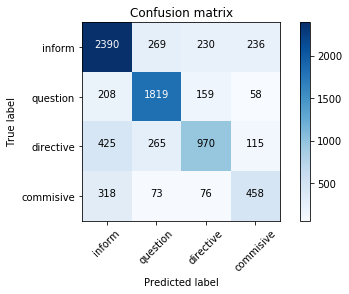

In [40]:
plot_confusion_matrix(cmat, classes)

Normalized confusion matrix
[[0.7648     0.08608    0.0736     0.07552   ]
 [0.09269162 0.81060606 0.07085561 0.0258467 ]
 [0.23943662 0.14929577 0.54647887 0.06478873]
 [0.34378378 0.07891892 0.08216216 0.49513514]]


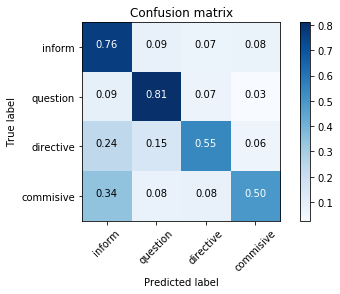

In [41]:
plot_confusion_matrix(cmat, classes, normalize=True)

In [42]:
correctPerClass = {}
totalPerClass   = {}
for cls in [0, 1, 2, 3]:
    correctPerClass[cls] = 0
    totalPerClass[cls]   = 0
for yt, yp in zip(valY_all, preds):
    totalPerClass[yt] += 1
    correctPerClass[yt] += int(yt==yp)



In [43]:
totalPerClass

{0: 3125, 1: 2244, 2: 1775, 3: 925}

In [44]:
correctPerClass

{0: 2390, 1: 1819, 2: 970, 3: 458}

In [45]:
for cls in [0, 1, 2, 3]:
    acc = float(correctPerClass[cls])/totalPerClass[cls]
    print("Accuracy for class ", cls, " :", acc)

('Accuracy for class ', 0, ' :', 0.7648)
('Accuracy for class ', 1, ' :', 0.8106060606060606)
('Accuracy for class ', 2, ' :', 0.5464788732394367)
('Accuracy for class ', 3, ' :', 0.49513513513513513)


# Saving the transition params

In [46]:
x = tf.Variable([[1.0, 2.0], [3, 1]])

init = tf.global_variables_initializer()

sess = tf.Session()
sess.run(init)
v = sess.run(transition_params)    

In [47]:
np.savetxt('transition_params_crf_v3.csv', v, delimiter=',')